In [208]:
# Python 3
import http.client, urllib.parse
import json
import pprint
import yfinance
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import sklearn.linear_model as SKmodels
import joblib

# API keys

In [2]:
API_STOCK_DATA = "Ab0Eq9OSOkVaNe9eluoMjkxSgnrFk46h08ghta6w"
API_ALPHA_VANTAGE = "Y55JGW1SYPKKETDD"

# Stock data API

In [3]:
# conn = http.client.HTTPSConnection('api.stockdata.org')
#
# params = urllib.parse.urlencode({
#     'api_token': API_STOCK_DATA,
#     'symbols': 'AAPL',
#     'interval': 'minute',
#     'date_from': '2021-01-01',
#     'date_to': '2022-01-01'
#     })
#
# conn.request('GET', '/v1/data/intraday?{}'.format(params))
#
# res = conn.getresponse()
# data = res.read()
# json.loads(data.decode('utf-8'))

# Alpha vantage

In [4]:
# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=1min&apikey={API_ALPHA_VANTAGE}'
# r = requests.get(url)
# dataVIX = r.json()
# dataVIX

# Yfinance

,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Volume,VIX_Dividends,VIX_Stock Splits
Datetime,,,,,,,
2022-04-19 14:31:00+01:00,22.500000,22.570000,22.459999,22.570000,0,0,0
2022-04-19 14:32:00+01:00,22.620001,22.660000,22.620001,22.629999,0,0,0
2022-04-19 14:33:00+01:00,22.570000,22.570000,22.450001,22.450001,0,0,0
2022-04-19 14:34:00+01:00,22.469999,22.469999,22.379999,22.379999,0,0,0
2022-04-19 14:35:00+01:00,22.430000,22.500000,22.430000,22.500000,0,0,0
...,...,...,...,...,...,...,...
2022-04-27 20:56:00+01:00,31.910000,32.040001,31.910000,32.040001,0,0,0
2022-04-27 20:57:00+01:00,32.020000,32.099998,32.020000,32.060001,0,0,0
2022-04-27 20:58:00+01:00,32.060001,32.150002,32.060001,32.150002,0,0,0


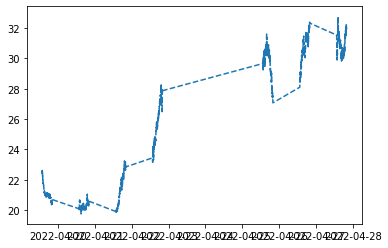

In [5]:
# Download VIX information
ticker = yfinance.Ticker('^VIX')
VIX = ticker.history(interval='1m', period='7d')
VIX.index = pd.to_datetime(VIX.index).tz_convert(tz='Europe/London')
VIX.columns = [f"VIX_{_}" for _ in VIX.columns]
plt.plot(VIX.VIX_Open, '--')
VIX

,CHFJPY_Open,CHFJPY_High,CHFJPY_Low,CHFJPY_Close,CHFJPY_Volume,CHFJPY_Dividends,CHFJPY_Stock Splits
Datetime,,,,,,,
2022-04-19 00:00:00+01:00,134.516998,134.528000,134.509995,134.526993,0,0,0
2022-04-19 00:01:00+01:00,134.524994,134.526001,134.505997,134.524002,0,0,0
2022-04-19 00:02:00+01:00,134.522995,134.539001,134.509995,134.533005,0,0,0
2022-04-19 00:03:00+01:00,134.520004,134.539993,134.520004,134.535004,0,0,0
2022-04-19 00:04:00+01:00,134.535995,134.537994,134.520004,134.533997,0,0,0
...,...,...,...,...,...,...,...
2022-04-27 20:58:00+01:00,132.419998,132.438995,132.410004,132.421997,0,0,0
2022-04-27 20:59:00+01:00,132.425995,132.466995,132.410004,132.462997,0,0,0
2022-04-27 21:00:00+01:00,132.464005,132.507004,132.449997,132.503998,0,0,0


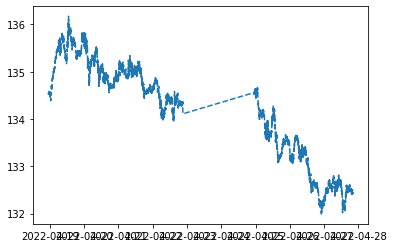

In [6]:
# Download CHFJPY information
ticker = yfinance.Ticker('CHFJPY=X')
CHFJPY = ticker.history(interval='1m', period='7d').iloc[:-15]
CHFJPY.index = pd.to_datetime(CHFJPY.index).tz_convert(tz='Europe/London')
CHFJPY.columns = [f"CHFJPY_{_}" for _ in CHFJPY.columns]
plt.plot(CHFJPY.CHFJPY_Open, '--')
CHFJPY

,GOLD_Open,GOLD_High,GOLD_Low,GOLD_Close,GOLD_Volume,GOLD_Dividends,GOLD_Stock Splits
Datetime,,,,,,,
2022-04-20 05:00:00+01:00,1945.699951,1946.000000,1945.599976,1945.599976,0,0,0
2022-04-20 05:01:00+01:00,1945.300049,1945.400024,1945.000000,1945.300049,75,0,0
2022-04-20 05:02:00+01:00,1945.300049,1945.599976,1945.199951,1945.400024,66,0,0
2022-04-20 05:03:00+01:00,1945.500000,1945.599976,1945.400024,1945.400024,8,0,0
2022-04-20 05:04:00+01:00,1945.199951,1945.199951,1941.000000,1943.599976,894,0,0
...,...,...,...,...,...,...,...
2022-04-27 20:49:00+01:00,1886.900024,1887.599976,1886.900024,1887.199951,72,0,0
2022-04-27 20:50:00+01:00,1887.199951,1887.300049,1887.000000,1887.300049,70,0,0
2022-04-27 20:51:00+01:00,1887.199951,1887.199951,1886.699951,1886.699951,122,0,0


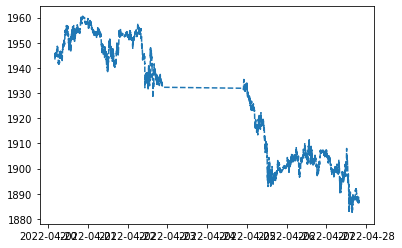

In [7]:
# Download Gold information
ticker = yfinance.Ticker('GC=F')
GOLD = ticker.history(interval='1m', period='7d').iloc[:-15]
GOLD.index = pd.to_datetime(GOLD.index).tz_convert(tz='Europe/London')
GOLD.columns = [f"GOLD_{_}" for _ in GOLD.columns]
plt.plot(GOLD.GOLD_Open, '--')
GOLD

In [224]:
# Merge both dataFrames. Cut part with causes by yahooFinance shift of VIX
merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
nan = np.any(merged.isna(), axis=1)
nan = nan.where(np.logical_not(nan)).first_valid_index()
merged = merged.loc[nan:]
merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
             'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
             'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
            axis=1, inplace=True)

del nan
# Create Mean by rolling on rollParam value.
rollParam = 100
CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
merged['CHFJPY_Vol'] = CHFJPY_roll.std()
merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

VIX_roll = merged.rolling(rollParam)['VIX_Open']
merged['VIX_Vol'] = VIX_roll.std()
merged['VIX_Mean'] = VIX_roll.mean()

GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
merged['GOLD_Vol'] = GOLD_roll.std()
merged['GOLD_Mean'] = GOLD_roll.mean()

merged = merged.iloc[rollParam:]

predictionMean = 10
merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
merged = merged.iloc[:-predictionMean]
del CHFJPY_roll, VIX_roll, GOLD_roll

merged

,CHFJPY_Open,CHFJPY_High,CHFJPY_Low,CHFJPY_Close,VIX_Open,VIX_High,VIX_Low,VIX_Close,FiniteVixData,GOLD_Open,...,GOLD_Low,GOLD_Close,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-20 06:40:00+01:00,135.320007,135.324005,135.300003,135.313995,20.709999,20.719999,20.709999,20.709999,True,1947.500000,...,1947.400024,1947.400024,False,0.078399,135.17386,0.000000,20.709999,1.069645,1945.890000,135.20231
2022-04-20 06:41:00+01:00,135.309998,135.350998,135.300003,135.330002,20.709999,20.719999,20.709999,20.709999,True,1947.400024,...,1947.400024,1948.000000,False,0.077824,135.17685,0.000000,20.709999,1.078523,1945.911000,135.20477
2022-04-20 06:42:00+01:00,135.339996,135.339996,135.289993,135.319000,20.709999,20.719999,20.709999,20.709999,True,1947.800049,...,1947.500000,1948.099976,False,0.077804,135.18009,0.000000,20.709999,1.093095,1945.936000,135.20702
2022-04-20 06:43:00+01:00,135.296997,135.309998,135.270004,135.287994,20.709999,20.719999,20.709999,20.709999,True,1948.000000,...,1947.900024,1948.199951,False,0.076270,135.18316,0.000000,20.709999,1.111456,1945.961000,135.20911
2022-04-20 06:44:00+01:00,135.287994,135.304001,135.279999,135.291000,20.709999,20.719999,20.709999,20.709999,True,1948.199951,...,1947.800049,1947.800049,False,0.074680,135.18605,0.000000,20.709999,1.131022,1945.991000,135.21073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-27 20:48:00+01:00,132.459000,132.466995,132.429993,132.438995,31.610001,31.760000,31.610001,31.760000,False,1887.099976,...,1886.699951,1886.900024,False,0.031994,132.47665,0.588530,31.070900,1.280480,1887.842001,132.46937
2022-04-27 20:49:00+01:00,132.438995,132.449005,132.429001,132.434006,31.790001,31.980000,31.790001,31.980000,False,1886.900024,...,1886.900024,1887.199951,False,0.032055,132.47596,0.586084,31.086900,1.238074,1887.799001,132.46870
2022-04-27 20:50:00+01:00,132.429993,132.442001,132.408997,132.423004,31.980000,32.270000,31.980000,32.270000,False,1887.199951,...,1887.000000,1887.300049,False,0.032161,132.47513,0.585749,31.104800,1.193671,1887.760001,132.46864


In [225]:
# merged['Target'] = 1 if (merged['CHFJPY_Mean_Future'] > merged['CHFJPY_Mean']) else 0
merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)

In [226]:
train, test = train_test_split(merged, shuffle=False)
scalePandas = MinMaxScaler()
train[train.columns] = scalePandas.fit_transform(train[train.columns])
train


,CHFJPY_Open,CHFJPY_High,CHFJPY_Low,CHFJPY_Close,VIX_Open,VIX_High,VIX_Low,VIX_Close,FiniteVixData,GOLD_Open,...,GOLD_Close,FiniteGOLDData,CHFJPY_Vol,CHFJPY_Mean,VIX_Vol,VIX_Mean,GOLD_Vol,GOLD_Mean,CHFJPY_Mean_Future,Target
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-20 06:40:00+01:00,0.918701,0.904995,0.919905,0.912443,0.080236,0.077966,0.081356,0.079526,1.0,0.807692,...,0.803546,0.0,0.248678,0.888436,0.000000e+00,0.059730,0.155042,0.784382,0.900985,1.0
2022-04-20 06:41:00+01:00,0.914632,0.915861,0.919905,0.918931,0.080236,0.077966,0.081356,0.079526,1.0,0.806213,...,0.812408,0.0,0.246151,0.889755,0.000000e+00,0.059730,0.156616,0.784710,0.902070,1.0
2022-04-20 06:42:00+01:00,0.926826,0.911432,0.915896,0.914471,0.080236,0.077966,0.081356,0.079526,1.0,0.812131,...,0.813885,0.0,0.246065,0.891184,0.000000e+00,0.059730,0.159199,0.785101,0.903062,1.0
2022-04-20 06:43:00+01:00,0.909347,0.899356,0.907891,0.901903,0.080236,0.077966,0.081356,0.079526,1.0,0.815089,...,0.815362,0.0,0.239316,0.892538,0.000000e+00,0.059730,0.162454,0.785491,0.903984,1.0
2022-04-20 06:44:00+01:00,0.905687,0.896941,0.911894,0.903122,0.080236,0.077966,0.081356,0.079526,1.0,0.818047,...,0.809455,0.0,0.232322,0.893813,0.000000e+00,0.059730,0.165922,0.785960,0.904698,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26 11:44:00+01:00,0.123577,0.132047,0.138967,0.128899,0.617399,0.618644,0.613559,0.610829,1.0,0.187869,...,0.190547,0.0,0.117702,0.065075,8.201764e-07,0.656935,0.170848,0.144729,0.070588,1.0
2022-04-26 11:45:00+01:00,0.132112,0.125197,0.142566,0.124848,0.617399,0.618644,0.613559,0.610829,1.0,0.190829,...,0.194977,0.0,0.116462,0.065825,8.201764e-07,0.656935,0.169799,0.145088,0.071091,1.0
2022-04-26 11:46:00+01:00,0.121952,0.130032,0.138967,0.123227,0.617399,0.618644,0.613559,0.610829,1.0,0.195266,...,0.189070,0.0,0.115611,0.066341,8.201764e-07,0.656935,0.168063,0.145557,0.071501,1.0


/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2688/1800871404.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2688/1800871404.py:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)


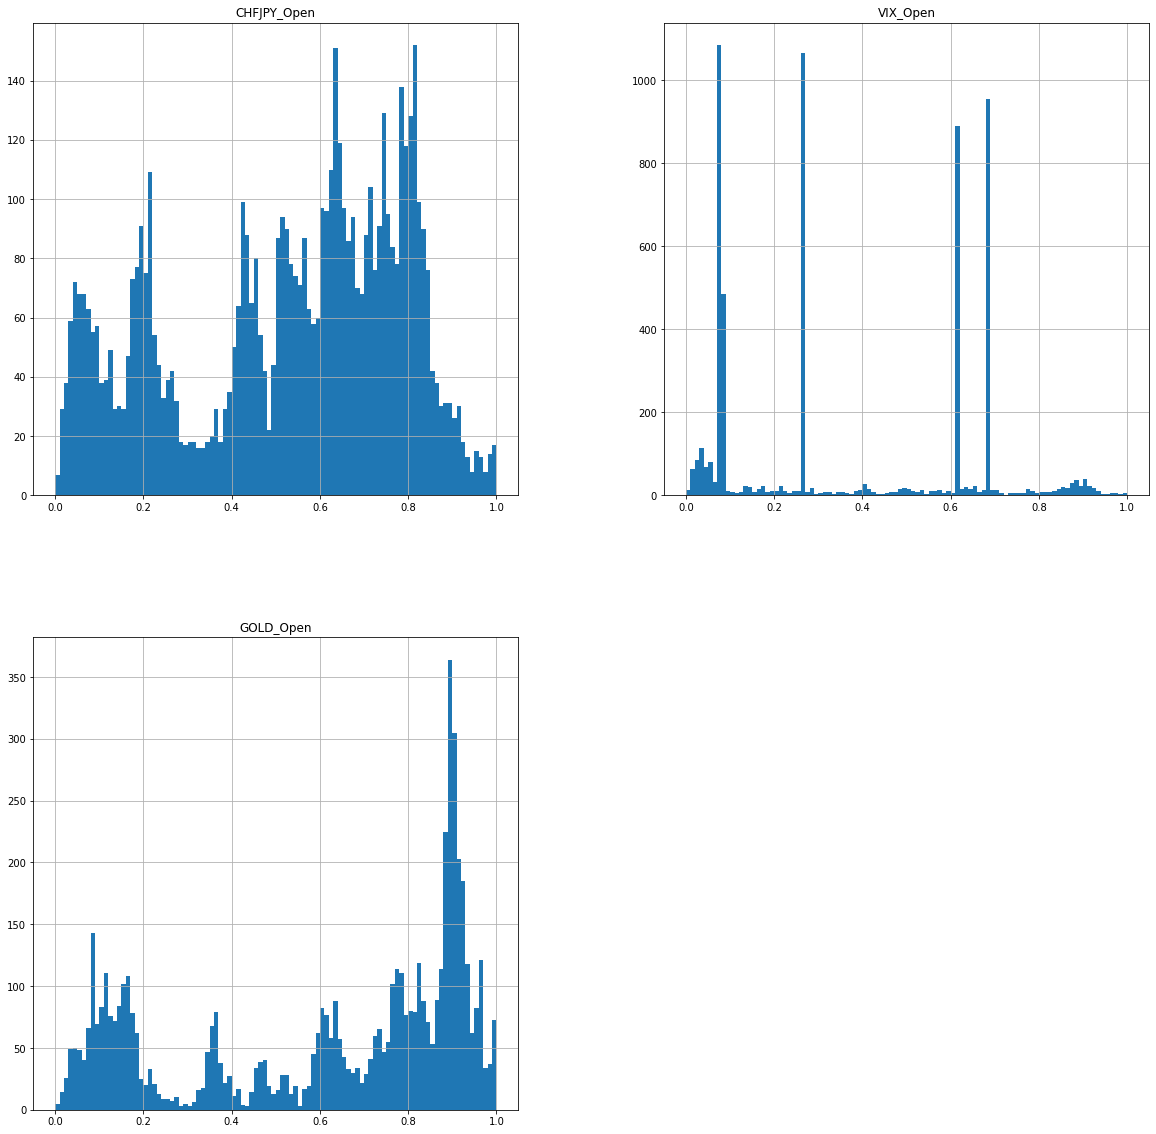

array([[<AxesSubplot:title={'center':'CHFJPY_Vol'}>,
        <AxesSubplot:title={'center':'VIX_Vol'}>],
       [<AxesSubplot:title={'center':'GOLD_Vol'}>, <AxesSubplot:>]],
      dtype=object)

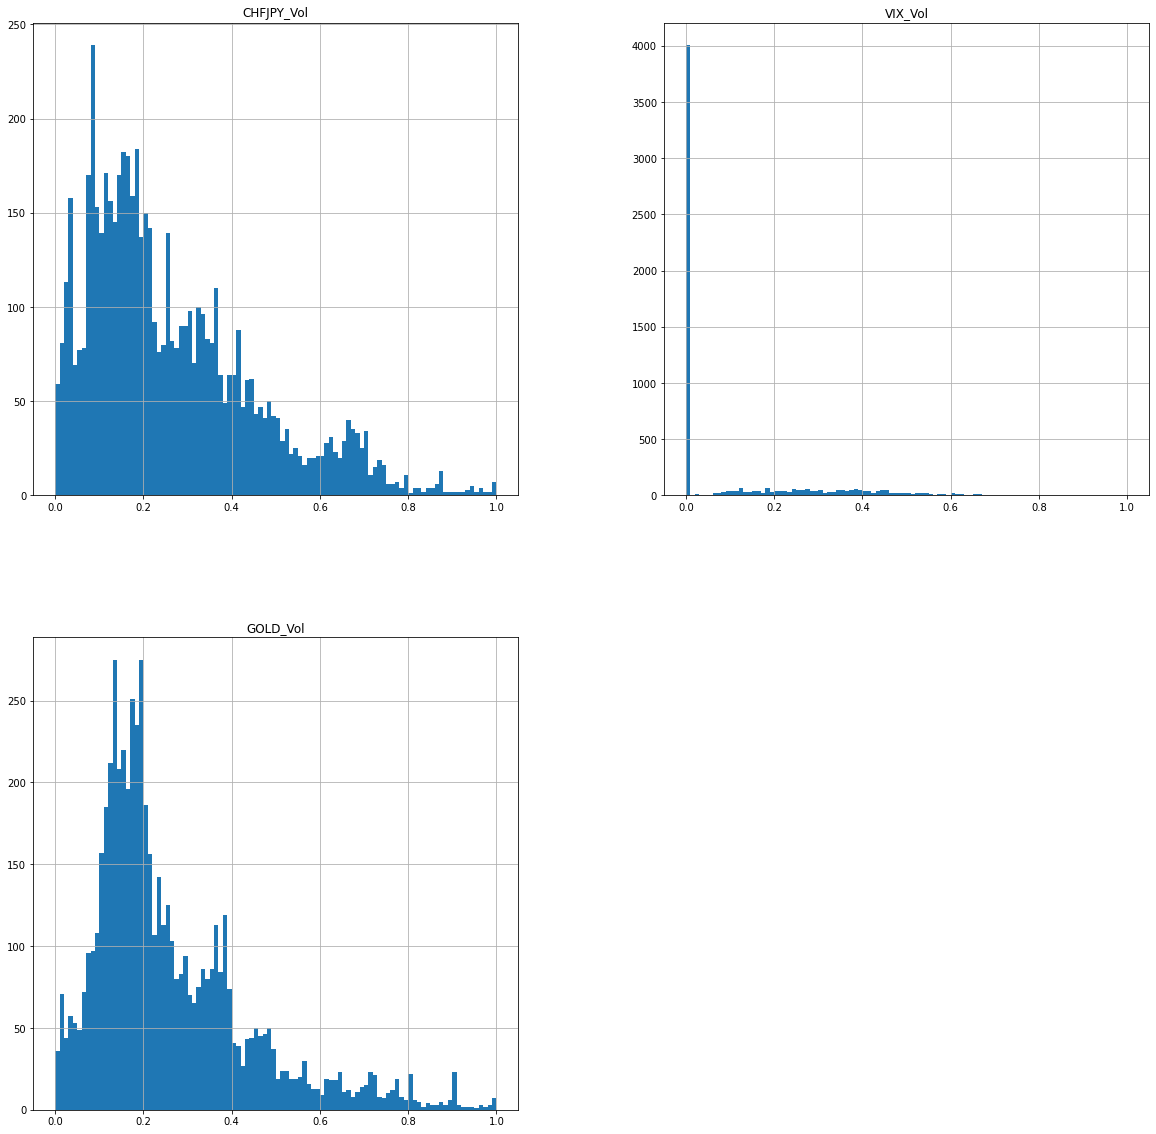

In [195]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.set_title('Open Histogram')
train[list(filter(lambda x: '_Open' in x, train.columns))].hist(ax=ax, bins=100)
plt.show()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
train[list(filter(lambda x: '_Vol' in x, train.columns))].hist(ax=ax, bins=100)

# Train Batch

In [227]:
trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = trainShifted.columns
for sf in SHIFT_ARRAY:
    shifted = trainShifted.shift(sf)
    for column in trainColumns:
        trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
train = train.iloc[max(SHIFT_ARRAY):]
train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)
train

,CHFJPY_Open,CHFJPY_High,CHFJPY_Low,CHFJPY_Close,VIX_Open,VIX_High,VIX_Low,VIX_Close,FiniteVixData,GOLD_Open,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-20 07:40:00+01:00,0.891464,0.876811,0.891868,0.883663,0.080236,0.077966,0.081356,0.079526,1.0,0.736686,...,0.000000e+00,0.059730,0.164421,0.788146,0.888436,0.248678,0.000000e+00,0.059730,0.155042,0.784382
2022-04-20 07:41:00+01:00,0.887805,0.876412,0.891868,0.884882,0.080236,0.077966,0.081356,0.079526,1.0,0.739645,...,0.000000e+00,0.059730,0.165033,0.788099,0.889755,0.246151,0.000000e+00,0.059730,0.156616,0.784710
2022-04-20 07:42:00+01:00,0.889430,0.879226,0.891868,0.887721,0.080236,0.077966,0.081356,0.079526,1.0,0.736686,...,0.000000e+00,0.059730,0.164514,0.788130,0.891184,0.246065,0.000000e+00,0.059730,0.159199,0.785101
2022-04-20 07:43:00+01:00,0.891868,0.886474,0.895877,0.888933,0.080236,0.077966,0.081356,0.079526,1.0,0.735207,...,0.000000e+00,0.059730,0.168162,0.787943,0.892538,0.239316,0.000000e+00,0.059730,0.162454,0.785491
2022-04-20 07:44:00+01:00,0.890242,0.883255,0.887866,0.882853,0.080236,0.077966,0.081356,0.079526,1.0,0.732249,...,0.000000e+00,0.059730,0.173441,0.787631,0.893813,0.232322,0.000000e+00,0.059730,0.165922,0.785960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26 11:44:00+01:00,0.123577,0.132047,0.138967,0.128899,0.617399,0.618644,0.613559,0.610829,1.0,0.187869,...,8.201764e-07,0.656935,0.177634,0.124738,0.058556,0.180818,8.201764e-07,0.656935,0.227352,0.111323
2022-04-26 11:45:00+01:00,0.132112,0.125197,0.142566,0.124848,0.617399,0.618644,0.613559,0.610829,1.0,0.190829,...,8.201764e-07,0.656935,0.170988,0.125613,0.058909,0.179758,8.201764e-07,0.656935,0.223256,0.112166
2022-04-26 11:46:00+01:00,0.121952,0.130032,0.138967,0.123227,0.617399,0.618644,0.613559,0.610829,1.0,0.195266,...,8.201764e-07,0.656935,0.167939,0.126659,0.059019,0.179957,8.201764e-07,0.656935,0.219828,0.113072


# Test Batch

In [228]:
testB = test
testB[testB.columns] = scalePandas.transform(testB[testB.columns])
testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
trainColumns = testShifted.columns
for sf in SHIFT_ARRAY:
    shifted = testShifted.shift(sf)
    for column in trainColumns:
        testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
del trainColumns
testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
testB = testB.iloc[max(SHIFT_ARRAY):]
testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
testB

,CHFJPY_Open,CHFJPY_High,CHFJPY_Low,CHFJPY_Close,VIX_Open,VIX_High,VIX_Low,VIX_Close,FiniteVixData,GOLD_Open,...,SHIFTED_40_VIX_Vol,SHIFTED_40_VIX_Mean,SHIFTED_40_GOLD_Vol,SHIFTED_40_GOLD_Mean,SHIFTED_60_CHFJPY_Mean,SHIFTED_60_CHFJPY_Vol,SHIFTED_60_VIX_Vol,SHIFTED_60_VIX_Mean,SHIFTED_60_GOLD_Vol,SHIFTED_60_GOLD_Mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-26 12:49:00+01:00,0.035771,0.051526,0.054863,0.040940,0.617399,0.618644,0.613559,0.610829,1.0,0.181952,...,8.201764e-07,0.656935,0.210180,0.159378,0.067752,0.117295,8.201764e-07,0.656935,0.159532,0.146916
2022-04-26 12:50:00+01:00,0.041869,0.037840,0.050861,0.040940,0.617399,0.618644,0.613559,0.610829,1.0,0.186390,...,8.201764e-07,0.656935,0.209550,0.159925,0.068233,0.117571,8.201764e-07,0.656935,0.155657,0.147447
2022-04-26 12:51:00+01:00,0.042278,0.047097,0.058866,0.043370,0.617399,0.618644,0.613559,0.610829,1.0,0.178994,...,8.201764e-07,0.656935,0.209427,0.160519,0.068837,0.121610,8.201764e-07,0.656935,0.153680,0.147884
2022-04-26 12:52:00+01:00,0.044716,0.051127,0.066480,0.049048,0.617399,0.618644,0.613559,0.610829,1.0,0.171597,...,8.201764e-07,0.656935,0.209358,0.161128,0.069441,0.121016,8.201764e-07,0.656935,0.153564,0.148134
2022-04-26 12:53:00+01:00,0.049597,0.053136,0.062875,0.045399,0.617399,0.618644,0.613559,0.610829,1.0,0.171597,...,8.201764e-07,0.656935,0.210472,0.161815,0.069975,0.117934,8.201764e-07,0.656935,0.153466,0.148649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-27 20:48:00+01:00,-0.244307,-0.245173,-0.229481,-0.252943,1.000845,1.013559,1.005085,1.014382,0.0,-0.085800,...,3.645687e-01,0.978093,0.271887,-0.097813,-0.279477,0.058592,1.792846e-01,0.966759,0.245859,-0.095861
2022-04-27 20:49:00+01:00,-0.252439,-0.252416,-0.229878,-0.254965,1.016047,1.032203,1.020339,1.032995,0.0,-0.088757,...,3.762955e-01,0.979342,0.274715,-0.098110,-0.279407,0.058187,1.809462e-01,0.967107,0.245535,-0.095830
2022-04-27 20:50:00+01:00,-0.256099,-0.255235,-0.237890,-0.259425,1.032095,1.056780,1.036441,1.057530,0.0,-0.084321,...,3.865981e-01,0.980563,0.277143,-0.098313,-0.279204,0.056764,1.823657e-01,0.967313,0.246182,-0.095892


# Forest

In [222]:
data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
target = train.Target
testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
testTarget = testB.Target

In [ ]:
forest = RandomForestClassifier(verbose=1, n_estimators=20, min_samples_leaf=43, criterion='entropy', n_jobs=-1,
                                max_depth=34, min_samples_split=40)
forest.fit(X=data, y=target)
# Train Score
print('Train Score', forest.score(X=data, y=target))

# Test Score
print('Test Score', forest.score(X=testData, y=testTarget))

# Ridge Classifier

In [223]:
classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
classifier.fit(X=data, y=target)
# Train Score
print('Train Score', classifier.score(X=data, y=target))
# Test Score
print('Test Score', classifier.score(X=testData, y=testTarget))

Train Score 0.8658847526772055
Test Score 0.8090530697190427


In [149]:
list(zip(classifier.coef_, train.drop(['Target'], axis=1).columns))

[(array([-4.14025334e-02,  1.18281261e-01, -6.37523382e-02,  6.79719554e-02,
         -1.16554361e-01,  2.19958009e-02, -9.92008294e-02,  2.68708663e-02,
          5.65002024e-01,  4.84567735e-01,  5.49379297e-01,  3.97103737e-01,
          4.65235819e-01,  2.25168573e-01,  1.99053394e-01, -1.60858651e+00,
          1.09594039e+00, -1.40215685e-02,  2.56867532e-01, -8.49993710e-02,
          8.58193563e+00, -1.68417956e+00, -1.65343600e-01,  6.42785831e-01,
         -8.97456987e-03, -1.22822751e-01, -1.15419883e-01, -1.70718113e+00,
         -9.62528156e-02,  2.68119698e-01, -7.47672579e-04, -3.04277411e-01,
         -1.51894848e-01, -1.67583290e+00, -2.96939924e-02, -7.92662547e-02,
          6.38629134e-03, -1.87448251e-01, -1.96581259e-01, -1.59986051e+00,
         -4.63843735e-02, -4.41289820e-01,  8.93068651e-03,  1.64601535e-01,
         -2.42672644e-01, -9.11398514e-01,  1.35461356e-01, -2.33350884e-01,
         -2.84858642e-03,  9.53657492e-01, -4.13615726e-01,  2.60254453e-01,

In [171]:
pd.Series(index=list(train.drop(['Target'], axis=1).columns), data=classifier.coef_[0])

CHFJPY_Open              -0.041403
CHFJPY_High               0.118281
CHFJPY_Low               -0.063752
CHFJPY_Close              0.067972
VIX_Open                 -0.116554
VIX_High                  0.021996
VIX_Low                  -0.099201
VIX_Close                 0.026871
FiniteVixData             0.565002
GOLD_Open                 0.484568
GOLD_High                 0.549379
GOLD_Low                  0.397104
GOLD_Close                0.465236
FiniteGOLDData            0.225169
CHFJPY_Vol                0.199053
CHFJPY_Mean              -1.608587
VIX_Vol                   1.095940
VIX_Mean                 -0.014022
GOLD_Vol                  0.256868
GOLD_Mean                -0.084999
CHFJPY_Mean_Future        8.581936
SHIFTED_5_CHFJPY_Mean    -1.684180
SHIFTED_5_CHFJPY_Vol     -0.165344
SHIFTED_5_VIX_Vol         0.642786
SHIFTED_5_VIX_Mean       -0.008975
SHIFTED_5_GOLD_Vol       -0.122823
SHIFTED_5_GOLD_Mean      -0.115420
SHIFTED_10_CHFJPY_Mean   -1.707181
SHIFTED_10_CHFJPY_Vo

array([-4.14025334e-02,  1.18281261e-01, -6.37523382e-02,  6.79719554e-02,
       -1.16554361e-01,  2.19958009e-02, -9.92008294e-02,  2.68708663e-02,
        5.65002024e-01,  4.84567735e-01,  5.49379297e-01,  3.97103737e-01,
        4.65235819e-01,  2.25168573e-01,  1.99053394e-01, -1.60858651e+00,
        1.09594039e+00, -1.40215685e-02,  2.56867532e-01, -8.49993710e-02,
        8.58193563e+00, -1.68417956e+00, -1.65343600e-01,  6.42785831e-01,
       -8.97456987e-03, -1.22822751e-01, -1.15419883e-01, -1.70718113e+00,
       -9.62528156e-02,  2.68119698e-01, -7.47672579e-04, -3.04277411e-01,
       -1.51894848e-01, -1.67583290e+00, -2.96939924e-02, -7.92662547e-02,
        6.38629134e-03, -1.87448251e-01, -1.96581259e-01, -1.59986051e+00,
       -4.63843735e-02, -4.41289820e-01,  8.93068651e-03,  1.64601535e-01,
       -2.42672644e-01, -9.11398514e-01,  1.35461356e-01, -2.33350884e-01,
       -2.84858642e-03,  9.53657492e-01, -4.13615726e-01,  2.60254453e-01,
        6.95904942e-02,  

In [109]:
print(classifier.predict(testData))

[0. 0. 0. ... 0. 0. 0.]


(array([0., 1.]), array([1052,  847]))

In [96]:
classifier = SKmodels.LogisticRegression(penalty='elasticnet', l1_ratio=0.4, C=0.5, solver='saga')
classifier.fit(X=trainShifted.values, y=train.Target)
# Train Score
print('Train Score', classifier.score(X=trainShifted.values, y=train.Target))
# Test Score
print('Test Score', classifier.score(X=testShifted.values, y=testB.Target))

Train Score 0.7396836313617606
Test Score 0.4460242232754081


In [234]:
import warnings


def make_score(value):
    warnings.filterwarnings("ignore")
    merged = CHFJPY.merge(VIX, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteVixData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[VIX.columns] = merged[VIX.columns].fillna(method='ffill')

    merged = merged.merge(GOLD, left_index=True, right_index=True, how='left')
    nan = np.any(merged.isna(), axis=1)
    nan = nan.where(np.logical_not(nan)).first_valid_index()
    merged = merged.loc[nan:]
    merged['FiniteGOLDData'] = np.any(merged.isna(), axis=1)[nan:]
    merged[GOLD.columns] = merged[GOLD.columns].fillna(method='ffill')
    merged.drop(['CHFJPY_Volume', 'CHFJPY_Dividends',
                 'CHFJPY_Stock Splits', 'VIX_Volume', 'VIX_Dividends', 'VIX_Stock Splits',
                 'GOLD_Stock Splits', 'GOLD_Dividends', 'GOLD_Volume'],
                axis=1, inplace=True)

    del nan
    # Create Mean by rolling on rollParam value.
    rollParam = 100
    CHFJPY_roll = merged.rolling(rollParam)['CHFJPY_Open']
    merged['CHFJPY_Vol'] = CHFJPY_roll.std()
    merged['CHFJPY_Mean'] = CHFJPY_roll.mean()

    VIX_roll = merged.rolling(rollParam)['VIX_Open']
    merged['VIX_Vol'] = VIX_roll.std()
    merged['VIX_Mean'] = VIX_roll.mean()

    GOLD_roll = merged.rolling(rollParam)['GOLD_Open']
    merged['GOLD_Vol'] = GOLD_roll.std()
    merged['GOLD_Mean'] = GOLD_roll.mean()

    merged = merged.iloc[rollParam:]

    predictionMean = value
    merged['CHFJPY_Mean_Future'] = merged['CHFJPY_Mean'].shift(-predictionMean)
    merged = merged.iloc[:-predictionMean]
    del CHFJPY_roll, VIX_roll, GOLD_roll
    merged['Target'] = merged.apply(lambda x: 1 if x.CHFJPY_Mean_Future > x['CHFJPY_Mean'] else 0, axis=1)
    train, test = train_test_split(merged, shuffle=False)
    scalePandas = MinMaxScaler()
    train[train.columns] = scalePandas.fit_transform(train[train.columns])
    trainShifted = train[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = trainShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = trainShifted.shift(sf)
        for column in trainColumns:
            trainShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    trainShifted = trainShifted.iloc[max(SHIFT_ARRAY):]
    train = train.iloc[max(SHIFT_ARRAY):]
    train = train.merge(trainShifted[list(filter(lambda x: x not in train.columns, trainShifted.columns))], left_index=True, right_index=True)

    testB = test
    testB[testB.columns] = scalePandas.transform(testB[testB.columns])
    testShifted = testB[['CHFJPY_Mean', 'CHFJPY_Vol', 'VIX_Vol', 'VIX_Mean', 'GOLD_Vol', 'GOLD_Mean']]
    SHIFT_ARRAY = [5, 10, 15, 20, 40, 60]
    trainColumns = testShifted.columns
    for sf in SHIFT_ARRAY:
        shifted = testShifted.shift(sf)
        for column in trainColumns:
            testShifted[f"SHIFTED_{sf}_{column}"] = shifted[column]
    del trainColumns
    testShifted = testShifted.iloc[max(SHIFT_ARRAY):]
    testB = testB.iloc[max(SHIFT_ARRAY):]
    testB = testB.merge(testShifted[list(filter(lambda x: x not in testB.columns, testShifted.columns))], left_index=True, right_index=True)
    data = train.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    target = train.Target
    testData = testB.drop(['Target', 'CHFJPY_Mean_Future'], axis=1).values
    testTarget = testB.Target
    classifier = SKmodels.RidgeClassifier(alpha=.3, solver='lsqr')
    classifier.fit(X=data, y=target)
    return [value, classifier.score(X=testData, y=testTarget)]

with pd.option_context('mode.chained_assignment',None):
    RES = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(make_score)(x) for x in list(range(10, 400, 5)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.3s finished


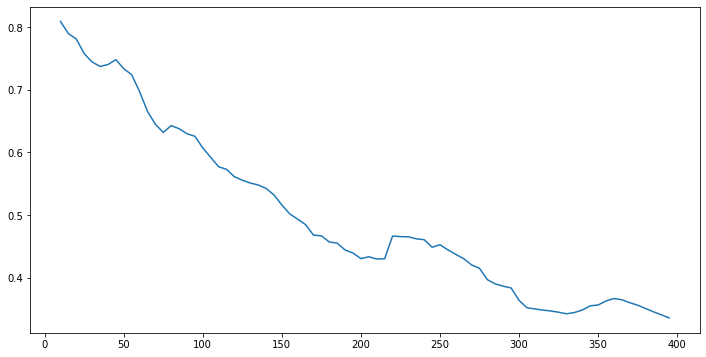

In [235]:
plt.figure(figsize=(12,6))
plt.plot([x[0] for x in RES], [x[1] for x in RES])